# Mass Balance Tuning 

In [2]:
import numpy as np
import xarray as xr
import pandas as pd 
# import seaborn as sns
from scipy import optimize
from scipy import interpolate
from scipy import linalg as LA
import matplotlib.pyplot as plt 

# local functions
from MB_tune import *

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')


# Load Erik's reference mass balance runs for the 25 parameter
# combinations which statisfy his tuning criteria
MB_ref =  xr.open_dataset("Young_etal_2020_ref_MB.nc")

In [3]:
x2, y2, p   = poly_fit( MB_ref.mean('ref_run').stack(z=('x', 'y')),  deg=2, ret_p=True)
x3, y3, tck = spline_fit(MB_ref.mean('ref_run').stack(z=('x', 'y')), deg=3, ret_p=True)

In [5]:
x_new = np.linspace(-250, 3500, 1000)

np.savetxt('../../include/fitpack/test/data/knots.dat', tck[0])
np.savetxt('../../include/fitpack/test/data/coefs.dat', tck[1])
np.savetxt('../../include/fitpack/test/data/x_vec.dat', x_new)

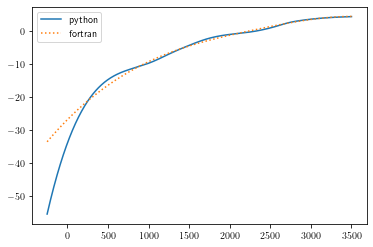

In [6]:
y_fortran = np.loadtxt('../../include/fitpack/test/data/y_vec.dat')
# evaluate the spline in python
y_python  = interpolate.splev(x_new, tck)

fig, ax = plt.subplots(1,1)

ax.plot(x_new, y_python , label ='python')
ax.plot(x_new, y_fortran, ':', markersize=1.0, label='fortran')

plt.legend()

plt.savefig("/Users/andrewnolan/Desktop/spline.png", dpi=400, 
            bbox_inches='tight', facecolor='w')

In [7]:
z = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
b = MB_ref.mean('ref_run').stack(z=('x', 'y')).MB.values
z_ELA = np.nanmean(z[np.argpartition(np.abs(b),25)[:25]])

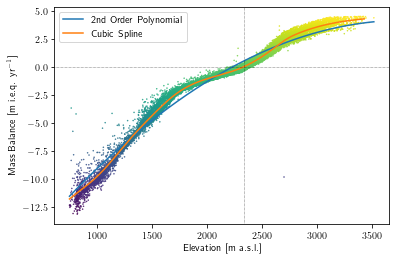

In [8]:
fig, ax = plt.subplots(1,1)

ax.scatter(  MB_ref.Elevation, 
             MB_ref.MB.mean('ref_run'),
           c=MB_ref.MB.mean('ref_run'),
           s=0.25)


ax.plot(x2, y2, label='2nd Order Polynomial')
ax.plot(x3, y3, label='Cubic Spline')

ax.legend()

ax.axhline(0, ls=':', c='k', lw=0.5)
ax.axvline(z_ELA, ls=':', c='k', lw=0.5)

ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('./figs/Mb_fits.png', dpi=400, bbox_inches='tight',
            facecolor='white')

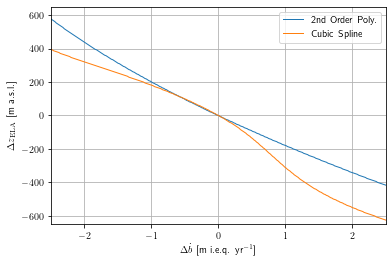

In [9]:
δb_2nd, ELAs_2nd, b_2nd = pert_ela(x3,   p, δb_bounds=(-2.5, 2.5))
δb_3rd, ELAs_3rd, b_3rd = pert_ela(x3, tck, δb_bounds=(-2.5, 2.5))

ΔELA_2nd = ELAs_2nd - ELAs_2nd[tuple([np.argpartition(np.abs(δb_2nd[0]),2)[:2]])].mean()
ΔELA_3rd = ELAs_3rd - ELAs_3rd[tuple([np.argpartition(np.abs(δb_3rd[0]),2)[:2]])].mean()

fig, ax = plt.subplots(1,1)

ax.plot(δb_2nd[0], ΔELA_2nd, lw=1.0, label='2nd Order Poly.')
ax.plot(δb_3rd[0], ΔELA_3rd, lw=1.0, label='Cubic Spline')
ax.legend()

ax.grid(which='both')

ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-650, 650)

ax.set_ylabel('$\Delta z_{\\rm ELA}$ [m a.s.l.]')
ax.set_xlabel('$\Delta \\dot{b}$ [m i.e.q. yr$^{-1}$]')

fig.savefig('./figs/delta_ELA.png', dpi=400, bbox_inches='tight',
            facecolor='white')

/var/folders/g3/nkh04ckd39jcftknlklg_vnh0000gn/T/ipykernel_7942/1098063190.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  term = np.where(np.diff(mask.astype(np.int))!=0)[0][0]
/var/folders/g3/nkh04ckd39jcftknlklg_vnh0000gn/T/ipykernel_7942/1098063190.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

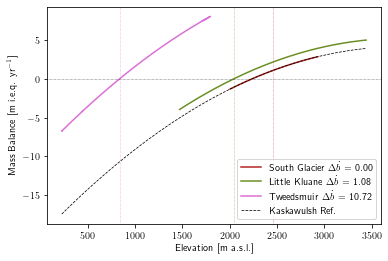

In [10]:
fig, ax = plt.subplots(1,1)

z_mins = []; z_maxs = []
labels = ['South Glacier', "Little Kluane", "Tweedsmuir"]
colors = ['firebrick', 'olivedrab', 'orchid']
for i, key in enumerate(['glc1-a', 'lilk-a', 'twds-a']): 
    
    sfp   = '../../input_data/{}_surf.dat'.format(key)
    bfp   = '../../input_data/{}_bed.dat'.format(key)
    
    sdat = np.loadtxt(sfp)
    bdat = np.loadtxt(bfp)
    
    x    = sdat[:,0]
    z_s  = sdat[:,1]
    z_b  = bdat[:,1]
    
    z_mins.append(z_s.min())
    z_maxs.append(z_s.max())
    
    mask = z_s <= z_b
    term = np.where(np.diff(mask.astype(np.int))!=0)[0][0]
    L    = (x[-1]-x[term])

    
    idx = np.abs(x - (x[term] + L/2)).argmin()
  
    δbs, ELAs, ref_b = pert_ela(z_s[term:], p, δb_bounds=(0.0, 15.0))

    δb = δbs[0,np.abs(ELAs - z_s[idx]).argmin()]
    
    ax.axvline(z_s[idx], c= colors[i], ls = ":",  lw=0.5)
    ax.plot(z_s[term:],
            ref_b[:] + δb, c= colors[i], 
            label='{:>25} $\Delta \dot{{b}} =$ {:3.2f}'.format(labels[i], δb))

z_full = np.linspace(min(z_mins), max(z_maxs))
b_full = np.polyval(p, z_full)

ax.axhline(0, ls=':', c='k', lw=0.5)
ax.plot(z_full,b_full, c='k', lw = 0.75, ls = '--', label = 'Kaskawulsh Ref.')
ax.legend()

ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('./figs/ELA_shifts.png', dpi=400, bbox_inches='tight',
            facecolor='white')

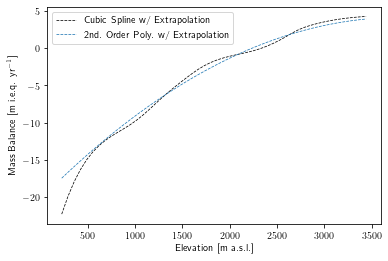

In [11]:
fig, ax = plt.subplots(1,1)

z_full = np.linspace(min(z_mins), max(z_maxs))
cubic  = interpolate.splev(z_full, tck)
quad   = np.polyval(p, z_full)


ax.plot(z_full,cubic, c='k', lw = 0.75, ls = '--', label = 'Cubic Spline w/ Extrapolation')
ax.plot(z_full,quad,lw = 0.75, ls = '--', label = '2nd. Order Poly. w/ Extrapolation')

ax.legend() 

ax.set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('./figs/extrapolation.png', dpi=400, bbox_inches='tight',
            facecolor='white')

In [12]:
x = MB_ref.mean('ref_run').stack(z=('x', 'y')).Elevation.values
y = MB_ref.mean('ref_run').stack(z=('x', 'y')).MB.values

# find indexes of nans and sort indexes
mask = np.where(~np.isnan(x))
idxs = np.argsort(x[mask])

# Remove the nans and sort the data and downsample data so there are
# less verically overlappig points, causing the spline fitting to fail
x_sub = x[~np.isnan(x)][::10]
y_sub = y[~np.isnan(x)][::10]

m = len(x_sub)

idxs = np.argsort(x_sub, kind='heapsort')

x_ = x_sub[idxs]
y_ = y_sub[idxs]
w  = np.where(x_ > 3000., 10.0, 1.0 )

#tck  = interpolate.splrep(x_, y_, k=deg, s=s)

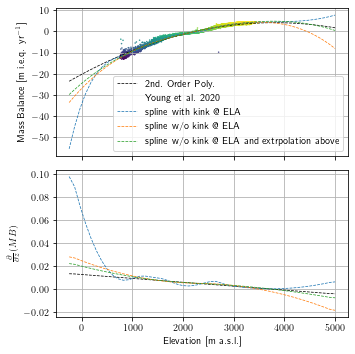

In [13]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(5,5))

z_full = np.linspace(-250, 5e3)
quad   = np.polyval(p, z_full)

ax[0].plot(z_full,quad,c='k', lw = 0.75, ls = '--', label = '2nd. Order Poly.')
ax[1].plot(z_full, np.gradient(quad, z_full), c='k', lw = 0.75, ls = '--')


ax[0].scatter(  MB_ref.Elevation, 
             MB_ref.MB.mean('ref_run'),
           c=MB_ref.MB.mean('ref_run'),
           s=0.25,
          label='Young et al. 2020')


labels = ['spline with kink @ ELA', 'spline w/o kink @ ELA', 'spline w/o kink @ ELA and extrpolation above']

for i, s in enumerate([240, 1500, 1500]):
    if i == 1:        
        w = np.where(x_ > 3000., 10, 1.0 )
    elif i == 2: 
        w = np.where((x_ > 3000.), 8.5, 1.0 )
        w = np.where((x_ < 1000.), 2.0, w)
    else: 
        w = np.ones(m) 

    tck   = interpolate.splrep(x_, y_, w=w, k=3, s=s)
    cubic = interpolate.splev(z_full, tck)
    
    ax[0].plot(z_full, cubic, lw = 0.75, ls = '--', label = labels[i])
    
    ax[1].plot(z_full, np.gradient(cubic, z_full),  lw = 0.75, ls = '--', )
    
    if i == 1: 
        np.savetxt(f'../../input_data/mass_balance/cubic_spline_knots_s_{s}_weighted.dat', tck[0])
        np.savetxt(f'../../input_data/mass_balance/cubic_spline_coefs_s_{s}_weighted.dat', tck[1])
    else: 
        np.savetxt(f'../../input_data/mass_balance/cubic_spline_knots_s_{s}.dat', tck[0])
        np.savetxt(f'../../input_data/mass_balance/cubic_spline_coefs_s_{s}.dat', tck[1])       
ax[0].legend()
ax[0].grid(True, which='both')
ax[1].grid(True, which='both')

ax[0].set_ylabel('Mass Balance [m i.e.q. yr$^{-1}$]')
ax[1].set_ylabel(r'$\frac{\partial}{\partial z} (MB)$')

ax[1].set_xlabel('Elevation    [m a.s.l.]')
plt.tight_layout()
fig.savefig("/Users/andrewnolan/Desktop/spline_smoothing.png", dpi = 400, 
            bbox_inches='tight', facecolor='w')

In [14]:
data = []

for fp in ['./result/twds-a/nc/twds-a_1000a_dt_1_dx_500_MB_10.0_OFF.nc',
           './result/twds-b/nc/twds-b_1000a_dt_1_dx_500_MB_10.0_OFF.nc']: 
    with xr.open_dataset(fp) as src: 
        # correct for minimum ice thickness
        src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
        # apply sigma coordinate transform for vertical coordinate
        src["Z"]     = src.zbed + src.Z * src.height 
        # Calculate the magnitude of the velocity vectors
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    
        
        data.append(src)
        
Vol1 = data[0].height.isel(coord_2=-1).integrate("coord_1") /\
       data[0].height.isel(coord_2=-1).isel(t=0).integrate("coord_1")
Vol2 = data[1].height.isel(coord_2=-1).integrate("coord_1") /\
       data[1].height.isel(coord_2=-1).isel(t=0).integrate("coord_1")

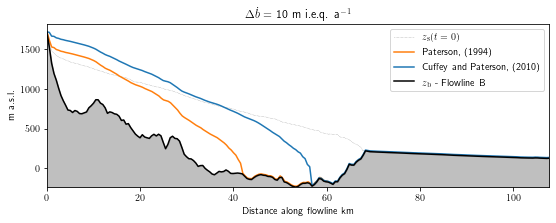

In [15]:
        
fig, ax = plt.subplots(figsize=(9,3))

ax.plot(data[1].coord_1[::-1]/1000.,
         data[1].isel(t=0,coord_2=-1).Z,
        color='k', ls=':', lw=0.5, alpha = 0.5, label=r'$z_{\rm s}(t=0)$')

ax.plot(data[0].coord_1[::-1]/1000.,
        xr.where(data[0].coord_1 <= 35e3, 
                 np.nan, 
                 data[0].Z.isel(t=-1,coord_2=-1)),
        color='tab:orange',
        label="Paterson, (1994)")

ax.plot(data[1].coord_1[::-1]/1000.,
        data[1].isel(t=-1,coord_2=-1).Z,
        color='tab:blue',
        label="Cuffey and Paterson, (2010)")

ax.plot(data[1].coord_1[::-1]/1000.,
        data[1].isel(t=0,coord_2=-1).zbed,
        color='k', label=r'$z_{\rm b}$ - Flowline B')

ax.fill_between(data[1].coord_1[::-1]/1000.,
                data[1].isel(t=0,coord_2=-1).zbed,
                y2 = np.minimum(data[1].isel(t=0,coord_2=-1).zbed.min(), 0.0),
                color='gray', alpha=0.5)

ax.set_ylabel('m a.s.l.')
ax.set_xlabel('Distance along flowline km')

ax.set_title('$\\Delta \\dot{b} = $ 10 m i.e.q. a$^{-1}$')
ax.legend()

ax.set_ylim(np.minimum(data[1].isel(t=0,coord_2=-1).zbed.min(), 0.0), None)
ax.set_xlim(0, np.max([data[i].coord_1.max()/1e3 for i in range(2)]))

fig.savefig('/Users/andrewnolan/Desktop/rate_factors_Zs.png', dpi=400, 
            bbox_inches='tight', facecolor='w')

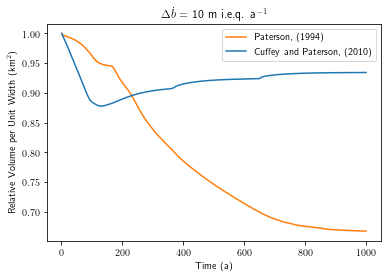

In [16]:
fig, ax = plt.subplots()

ax.plot(Vol1.t, Vol1, color='tab:orange', label="Paterson, (1994)")
ax.plot(Vol2.t, Vol2, color='tab:blue', label="Cuffey and Paterson, (2010)")

ax.set_title('$\\Delta \\dot{b} = $ 10 m i.e.q. a$^{-1}$')
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('Time (a)')
    
ax.legend()

fig.savefig('/Users/andrewnolan/Desktop/rate_factors_Vol.png', dpi=400, 
            bbox_inches='tight', facecolor='w')

In [17]:

mf_dataset = src 

In [18]:
profiling = np.loadtxt("./result/lilk-a/lilk-a.spinup.time_profile")

dx50_times  = np.where(profiling[:,0]==50,  profiling[:,2]/60., np.nan)
dx100_times = np.where(profiling[:,0]==100, profiling[:,2]/60., np.nan)
dx200_times = np.where(profiling[:,0]==200, profiling[:,2]/60., np.nan)

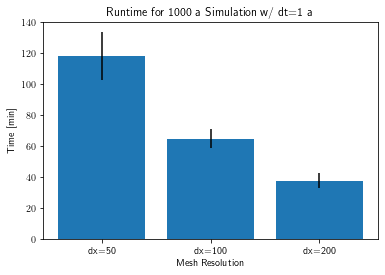

In [19]:
fig, ax = plt.subplots(1,1)

ax.bar(['dx=50', 'dx=100', 'dx=200'], 
       [np.nanmean(dx50_times), 
        np.nanmean(dx100_times), 
        np.nanmean(dx200_times)],
        yerr = [np.nanstd(dx50_times), 
                np.nanstd(dx100_times), 
                np.nanstd(dx200_times)])

ax.set_ylabel('Time [min]')
ax.set_xlabel('Mesh Resolution')

ax.set_title('Runtime for 1000 a Simulation w/ dt=1 a')

fig.savefig('./figs/lilk-a/runtime.png', dpi=400,
            bbox_inches='tight', facecolor='w')

In [20]:
with xr.open_dataset('./result/glc1-a/nc/glc1-a_1000a_dt_1_dx_100_MB_-1.0_OFF.nc') as src: 
    # correct for minimum ice thickness
    src["depth"] = xr.where(src.depth <= 10, 0, src.depth)
    # apply sigma coordinate transform for vertical coordinate
    src["Z"]     = src.zbed + src.Z * src.height 
    # Calculate the magnitude of the velocity vectors
    src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)    
    
Vol = src.height.isel(coord_2=-1).integrate("coord_1") /\
      src.height.isel(coord_2=-1).isel(t=0).integrate("coord_1")

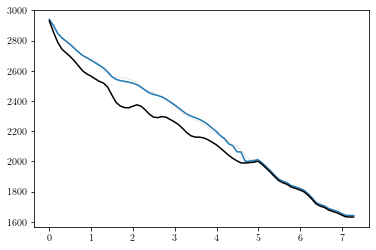

In [21]:
fig, ax = plt.subplots()
ax.plot(src.coord_1[::-1]/1000.,
        src.isel(t=0,coord_2=-1).Z,
        color='k', ls=':', lw=0.5, alpha = 0.5, label=r'$z_{\rm s}(t=0)$')


ax.plot(src.coord_1[::-1]/1000.,
        src.isel(t=300,coord_2=-1).Z,
        color='tab:blue',
        label="Cuffey and Paterson, (2010)")

ax.plot(src.coord_1[::-1]/1000.,
        src.isel(t=0,coord_2=-1).zbed,
        color='k', label=r'$z_{\rm b}$ - Flowline B')

# ax.fill_between(mf_dataset.coord_1[::-1]/1000.,
#                 mf_dataset.isel(t=0,coord_2=-1).zbed,
#                 y2 = np.minimum(mf_dataset.isel(t=0,coord_2=-1).zbed.min(), 0.0),
#                 color='gray', alpha=0.5)

In [22]:
Vol.isel(t=-1)

<xarray.DataArray 'height' ()>
array(0.9689336, dtype=float32)
Coordinates:
    coord_2  float32 1.0
    t        float32 1e+03

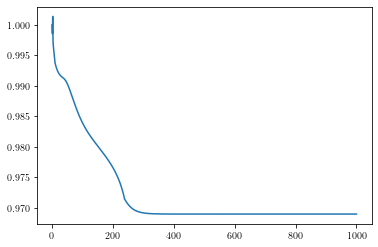

In [23]:
plt.plot(Vol.t, Vol)


In [26]:
def piecewise_fit(ds, deg=1, ret_p=True): 
    # Deal with nan's internally 
    x = ds.Elevation.values
    y = ds.Accumulation.values
    
    # find indexes of nans and sort indexes
    mask = np.where(~np.isnan(x))
    idxs = np.argsort(x[mask])
    
    # Remove the nans and sort the data
    x_ = x[  mask][idxs]
    y_ = y[mask  ][idxs]
    
    # Fit the model, optimize the slopes and y-intercepts 
    # (and therefore the knot point)
    p , e = optimize.curve_fit(piecewise_linear, x_, y_, p0=[ 2300,0,0,0])
    
    if ret_p:
        return x_, piecewise_linear(x_, *p), p
    else:
        return x_, piecewise_linear(x_, *p)


In [27]:
z_vec, A_vec, p = piecewise_fit( MB_ref.mean('ref_run').stack(z=('x', 'y')))

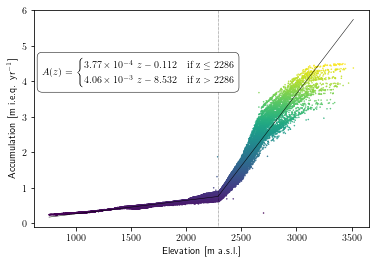

In [28]:
fig, ax = plt.subplots(1,1)

ax.scatter(MB_ref.Elevation, 
             MB_ref.Accumulation.mean('ref_run'),
           c=MB_ref.Accumulation.mean('ref_run'),
           s=0.25)

ax.plot(z_vec, A_vec, c='k', lw=0.5)

ax.axvline(p[0], ls=':', c='k', lw=0.5)


# piecewise linear equation
eq  = ("$A(z) = \\begin{{cases}}"
       " {0} \\; z {1:3.3f} & \\rm{{if }} \\; z \\leq {2:4.0f} \\\ "
       " {3} \\; z {4:3.3f} & \\rm{{if }} \\; z > {5:4.0f} \\\ "
       "\\end{{cases}}$".format(latex_float(p[2]),p[1]-p[2]*p[0],p[0],
                                latex_float(p[3]),p[1]-p[3]*p[0],p[0])
      )

ax.text(0.025, 0.7, eq, transform=ax.transAxes,
       bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.5,
                 linewidth=0.5))

ax.set_ylabel('Accumulation [m i.e.q. yr$^{-1}$]')
ax.set_xlabel('Elevation    [m a.s.l.]')

fig.savefig('./figs/Accum.png', dpi=400, bbox_inches='tight',
            facecolor='white')

## Mass Balance Formulation: 

[Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) model the snow accumulation $A_{\rm snow}$ as function of elevation such that: 
\begin{equation}
     A_{\rm snow}(z) = \sum^{365}_{d=1} 
    \begin{cases}
    \frac{A_{\rm ref}}{365} ( 1 +  (z-z_{\rm ref}) \frac{d A}{ d z})  & \text{if } T(d,z) < T_{\rm snow} ,\\
    0 & \text{if } T(d,z) \geq T_{\rm snow} ,
    \end{cases}
\end{equation}

where $A_{\rm ref}$ (m w.e. a$^{-1}$) is the mean annual precipitation at reference elevation $z_{\rm ref}$ (m a.s.l.), $\frac{d A}{ d z}$ (m$^{-1}$) is the altitudnal precipitation factor, and $T_{\rm snow}$ (K) is the temperature threshold to differeniate between snow and rain. 

__Note__: Units listed follow [Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) and not necessarily what we will end up using in our implementation. Also, $\frac{d A}{ d z}$ is refered to as the altitudnal precipitation factor and has units (m$^{-1}$), whereas we might commonly think of this
parameter as the mass balance gradient which would have units (m w.e. a$^{-1}$ m$^{-1}$). Despite the different units, the magnitude of the scalar quantity appears to be the same. 


Since we seek to model our selection of glaciers, we need to alter the [Gilbert et al. 2020](https://tc.copernicus.org/articles/14/1273/2020/) formulation slightly.

In [29]:
piecewise_linear(np.array([0,1000, 3500],dtype=np.float), *p)

/var/folders/g3/nkh04ckd39jcftknlklg_vnh0000gn/T/ipykernel_7942/1938438656.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  piecewise_linear(np.array([0,1000, 3500],dtype=np.float), *p)


array([-0.11192152,  0.26483472,  5.6763039 ])

In [ ]:
-0.112 + (1000)*3.77e-4

In [ ]:
(-8.532/183)